# **XGBoost from Scratch in Python**
*By Cristian Leo*

*Link Article*: https://medium.com/@cristianleo120/the-math-behind-xgboost-3068c78aad9d

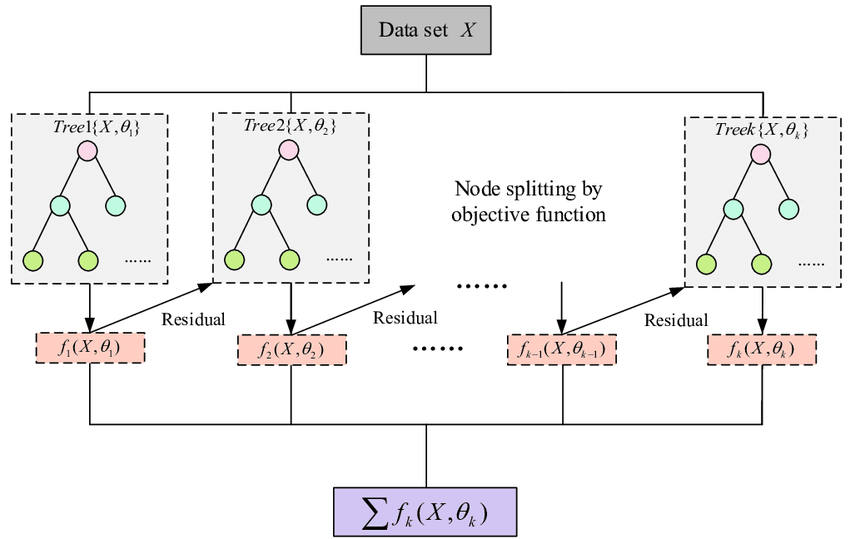
## **Import Required Libraries**

In [1]:
# Base Libraries
import numpy as np
import pandas as pd

# Data Prep
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Model Fine Tuning
import optuna

# Model Performance
from sklearn.metrics import classification_report

# Data Visualization
import plotly.express as px

## **Class Node**

In [2]:
class Node:
    """
    A node class for a decision tree.
    """
    def __init__(self, x, gradient, hessian, idxs, subsample_cols=1 , min_leaf=5, min_child_weight=1 ,depth=10, lambda_=1, gamma=1, eps=0.1):
        """
        Constructor to initialize the node with data and parameters.
        Parameters:
        - x: Input data for the node.
        - gradient: Gradient information for gradient boosting.
        - hessian: Hessian information for second-order optimization.
        - idxs: Indices of the data points in the node.
        - subsample_cols: Fraction of columns to consider for splitting.
        - min_leaf: Minimum number of samples required in a leaf node.
        - min_child_weight: Minimum sum of instance weight(hessian) needed in a child.
        - depth: Maximum depth of the tree.
        - lambda_: Regularization parameter.
        - gamma: Minimum loss reduction required to make a further partition.
        - eps: Epsilon value for quantile sketch method.
        """
        self.x, self.gradient, self.hessian = x, gradient, hessian
        self.idxs = idxs 
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])
        self.score = float('-inf')
        self.find_varsplit()
        
    def compute_gamma(self, gradient, hessian):
        """
        Computes the gamma value for the node.
        Gamma is calculated as negative sum of gradient divided by the sum of hessian plus lambda.
        
        Parameters:
        - gradient: Gradient information for gradient boosting.
        - hessian: Hessian information for second-order optimization.
        
        Returns:
        - gamma: Gamma value for the node.
        """
        return(-np.sum(gradient)/(np.sum(hessian) + self.lambda_))
        
    def find_varsplit(self):
        """
        Identifies the best variable to split on.
        Iterates through the subset of columns and finds the best greedy split.
        """
        for c in self.column_subsample: self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[lhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        self.rhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[rhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        
    def find_greedy_split(self, var_idx):
        """
        Finds the best split point for a given variable using a greedy approach.
        Iterates through each row and evaluates potential splits.

        Parameters:
        - var_idx: Index of the variable to split on.
        """
        x = self.x[self.idxs, var_idx]
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            lhs_indices = np.nonzero(lhs)[0]
            rhs_indices = np.nonzero(rhs)[0]
            lhs_sum = self.hessian[lhs_indices].sum()
            rhs_sum = self.hessian[rhs_indices].sum()
            # Ensures minimum leaf size and child weight before considering the split.
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or lhs_sum < self.min_child_weight
               or rhs_sum < self.min_child_weight): continue
            curr_score = self.gain(lhs, rhs)
            # Updates the best split if a better score is found.
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def weighted_qauntile_sketch(self, var_idx):
        """
        Finds the best split point for a given variable using a weighted quantile sketch approach.
        Iterates through each row and evaluates potential splits.

        Parameters:
        - var_idx: Index of the variable to split on.
        """
        x = self.x[self.idxs, var_idx]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'feature':x,'hess':hessian_})
        df.sort_values(by=['feature'], ascending = True, inplace = True)
        hess_sum = df['hess'].sum() 
        df['rank'] = df.apply(lambda x : (1/hess_sum)*sum(df[df['feature'] < x['feature']]['hess']), axis=1)
        
        for row in range(df.shape[0]-1):
            # look at the current rank and the next ran
            rk_sk_j, rk_sk_j_1 = df['rank'].iloc[row:row+2]
            diff = abs(rk_sk_j - rk_sk_j_1)
            if(diff >= self.eps):
                continue
                
            split_value = (df['rank'].iloc[row+1] + df['rank'].iloc[row])/2
            lhs = x <= split_value
            rhs = x > split_value
            
            lhs_indices = np.nonzero(x <= split_value)[0]
            rhs_indices = np.nonzero(x > split_value)[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue
                
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = split_value
                
    def gain(self, lhs, rhs):
        """
        Computes the gain in loss function for a given split.

        Parameters:
        - lhs: Left hand side of the split.
        - rhs: Right hand side of the split.

        Returns:
        - gain: Gain in loss function for the split.
        """
        gradient = self.gradient[self.idxs]
        hessian  = self.hessian[self.idxs]
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian  = hessian[lhs].sum()
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian  = hessian[rhs].sum()
        total_gradient = lhs_gradient + rhs_gradient
        total_hessian = lhs_hessian + rhs_hessian
        
        gain = 0.5 *( (lhs_gradient**2/(lhs_hessian + self.lambda_)) + (rhs_gradient**2/(rhs_hessian + self.lambda_)) - (total_gradient**2/(total_hessian + self.lambda_))) - self.gamma
        return(gain)
                
    @property
    def split_col(self):
        """
        Returns the column of the split variable.
        """
        return self.x[self.idxs , self.var_idx]
                
    @property
    def is_leaf(self):
        """
        Returns True if the node is a leaf node.
        """
        return self.score == float('-inf') or self.depth <= 0                 

    def predict(self, x):
        """
        Predicts the value for a given input.

        Parameters:
        - x: Input data.

        Returns:
        - np.array: Predicted values.
        """
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        """
        Predicts the value for a given input row.

        Parameters:
        - xi: Input row.

        Returns:
        - np.array: Predicted value.
        """
        if self.is_leaf:
            return(self.val)

        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

## **XGBoost Tree Class**

In [3]:
class XGBoostTree:
    def fit(self, x, gradient, hessian, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
        """
        Fits a decision tree to the data.

        Parameters:
        - x: Input data.
        - gradient: Gradient information for gradient boosting.
        - hessian: Hessian information for second-order optimization.
        - subsample_cols: Fraction of columns to consider for splitting.
        - min_leaf: Minimum number of samples required in a leaf node.
        - min_child_weight: Minimum sum of instance weight(hessian) needed in a child.
        - depth: Maximum depth of the tree.
        - lambda_: Regularization parameter.
        - gamma: Minimum loss reduction required to make a further partition.
        - eps: Epsilon value for quantile sketch method.

        Returns:
        - self: Trained decision tree.
        """
        self.dtree = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight, depth, lambda_, gamma, eps)
        return self
    
    def predict(self, X):
        """
        Predicts the value for a given input.

        Parameters:
        - X: Input data.

        Returns:
        - np.array: Predicted values.
        """
        return self.dtree.predict(X)

## **XGBoost Classifier Class**

In [4]:
class XGBoostClassifier:
    def __init__(self, random_state=None):
        self.estimators = []
        self.random_state = random_state
        np.random.seed(self.random_state)
    
    @staticmethod
    def sigmoid(x):
        """
        Computes the sigmoid function.
        
        Parameters:
        - x: Input data.
        
        Returns:
        - np.array: Sigmoid of the input data.
        """
        return 1 / (1 + np.exp(-x))
    
    def grad(self, preds, labels):
        """
        Computes the gradient of the log loss function.
        
        Parameters:
        - preds: Predicted values.
        - labels: Actual values.
        
        Returns:
        - np.array: Gradient of the log loss function.
        """
        preds = self.sigmoid(preds)
        return(preds - labels)
    
    def hess(self, preds, labels):
        """
        Computes the hessian of the log loss function.
        
        Parameters:
        - preds: Predicted values.
        
        Returns:
        - np.array: Hessian of the log loss function.
        """
        preds = self.sigmoid(preds)
        return(preds * (1 - preds))
    
    @staticmethod
    def log_odds(column):
        """
        Computes the log odds of a binary variable.

        Parameters:
        - column: Binary variable.

        Returns:
        - np.array: Log odds of the binary variable.
        """
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))
    
    
    def fit(self, X, y, subsample_cols=1 , min_child_weight=1, depth=5, min_leaf=5, learning_rate=0.1, boosting_rounds=10, lambda_=1.5, gamma=1, eps=0.1):
        """
        Fits a gradient boosted decision tree to the data.

        Parameters:
        - X: Input data.
        - y: Target variable.
        - subsample_cols: Fraction of columns to consider for splitting.
        - min_leaf: Minimum number of samples required in a leaf node.
        - min_child_weight: Minimum sum of instance weight(hessian) needed in a child.
        - depth: Maximum depth of the tree.
        - lambda_: Regularization parameter.
        - gamma: Minimum loss reduction required to make a further partition.
        - eps: Epsilon value for quantile sketch method.
        - learning_rate: Learning rate for gradient boosting.
        - boosting_rounds: Number of boosting rounds.

        Returns:
        - self: Trained gradient boosted decision tree.
        """
        self.X, self.y = X, y
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.base_pred = np.full((X.shape[0], 1), 1).flatten().astype('float64')
        Grad = self.grad(self.base_pred, self.y)
        Hess = self.hess(self.base_pred, self.y)
        for _ in range(self.boosting_rounds):
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)
          
    def predict_proba(self, X):
        """
        Predicts the probability of the positive class for a given input.

        Parameters:
        - X: Input data.

        Returns:
        - np.array: Predicted probabilities.
        """
        pred = np.zeros(X.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
          
        return self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
        
        predicted_probas = self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return preds

## **Load Breast Cancer Data**

In [5]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

## **EDA**
### **Distribution of Mean Radius**

In [6]:
fig = px.histogram(df, x="mean radius", nbins=20, title='Distribution of Mean Radius', color_discrete_sequence=['#636EFA'], template='plotly_dark')
fig.update_layout(
    xaxis_title='Mean Radius',
    yaxis_title='Count',
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

### **Box Plot of Mean Radius**

In [7]:
# Calculate the quantiles
q1 = np.percentile(df['mean radius'], 25)
q3 = np.percentile(df['mean radius'], 75)
median = np.median(df['mean radius'])

fig = px.box(df, y="mean radius", title='Box Plot of Mean Radius', template='plotly_dark')

# Customize the box plot
fig.update_traces(marker_color='#636EFA', line_color='#636EFA', boxmean=True)
fig.update_layout(
    xaxis_title='Mean Radius',
    yaxis_title='Count',
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    # Add annotations for the quantiles
    annotations=[
        dict(x=0.5, y=q1, xref='x', yref='y', text=f'Q1: {q1:.2f}', showarrow=False),
        dict(x=0.5, y=median, xref='x', yref='y', text=f'Median: {median:.2f}', showarrow=False),
        dict(x=0.5, y=q3, xref='x', yref='y', text=f'Q3: {q3:.2f}', showarrow=False)
    ]
)

fig.show()

### **Scatter matrix of selected features**

In [8]:
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
fig = px.scatter_matrix(df[selected_features], title='Scatter matrix of selected features', template='plotly_dark')

# Customize the scatter matrix plot
fig.update_traces(marker=dict(size=3, color='#636EFA'), diagonal_visible=False)
fig.update_layout(
    title_font=dict(size=20),
    font=dict(family='Courier New, monospace', size=10, color='#7f7f7f'),
    width=800,
    height=800
)

fig.show()

## **Fit XGBoost**

In [9]:
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

xgb = XGBoostClassifier(random_state=42)
xgb.fit(X_train, y_train, depth = 5, min_leaf = 5, lambda_ = 1.5, gamma = 1, eps = 0.1, min_child_weight = 1, subsample_cols = 0.8, learning_rate = 0.4, boosting_rounds = 5)
y_pred = xgb.predict(X_test)
print(f"Test Accuracy: {np.mean(y_pred == y_test):.2%}")
print(classification_report(y_test, y_pred))

Test Accuracy: 95.61%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [10]:
def objective(trial):
    depth = trial.suggest_int('depth', 3, 10)
    min_leaf = trial.suggest_int('min_leaf', 1, 10)
    lambda_ = trial.suggest_float('lambda_', 0.1, 2.0)
    gamma = trial.suggest_float('gamma', 0.1, 2.0)
    eps = trial.suggest_float('eps', 0.01, 0.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample_cols = trial.suggest_float('subsample_cols', 0.5, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1.0)
    boosting_rounds = trial.suggest_int('boosting_rounds', 3, 10)
    
    xgb = XGBoostClassifier(random_state=42)
    xgb.fit(X_train, y_train, depth=depth, min_leaf=min_leaf, lambda_=lambda_, gamma=gamma, eps=eps, min_child_weight=min_child_weight, subsample_cols=subsample_cols, learning_rate=learning_rate, boosting_rounds=boosting_rounds)
    y_pred = xgb.predict(X_test)
    accuracy = (y_test == y_pred).mean()
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_accuracy = study.best_value


[I 2024-01-10 11:29:33,881] A new study created in memory with name: no-name-fff7c5a4-0285-48d3-bb63-556f7bfe88be
[I 2024-01-10 11:29:36,035] Trial 0 finished with value: 0.9473684210526315 and parameters: {'depth': 3, 'min_leaf': 10, 'lambda_': 1.8837519939791678, 'gamma': 1.9326730633196363, 'eps': 0.12256918818403406, 'min_child_weight': 4, 'subsample_cols': 0.5257156428787195, 'learning_rate': 0.2901709548391574, 'boosting_rounds': 6}. Best is trial 0 with value: 0.9473684210526315.
[I 2024-01-10 11:29:39,921] Trial 1 finished with value: 0.868421052631579 and parameters: {'depth': 8, 'min_leaf': 6, 'lambda_': 0.36060611230704076, 'gamma': 1.846850132917239, 'eps': 0.2364774657260346, 'min_child_weight': 6, 'subsample_cols': 0.9376645896648708, 'learning_rate': 0.954536873479931, 'boosting_rounds': 5}. Best is trial 0 with value: 0.9473684210526315.
[I 2024-01-10 11:29:42,257] Trial 2 finished with value: 0.9473684210526315 and parameters: {'depth': 7, 'min_leaf': 9, 'lambda_': 0.1

In [11]:
print("Best Parameters:", best_params)
print(f"Best Accuracy on Test Data: {best_accuracy:.2%}")
print(classification_report(y_test, y_pred))

Best Parameters: {'depth': 5, 'min_leaf': 4, 'lambda_': 1.108237040552457, 'gamma': 1.6249386096671368, 'eps': 0.3936850691142478, 'min_child_weight': 2, 'subsample_cols': 0.6933452380097069, 'learning_rate': 0.20522781795497688, 'boosting_rounds': 3}
Best Accuracy on Test Data: 97.37%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        43
           1       0.97      0.96      0.96        71

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

